In [1]:
import numpy as np
import pandas as pd
import time
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import ParameterGrid
import xgboost as xgb
sns.set()

In [2]:
df = pd.read_csv(r'C:\Users\cqq13\Desktop\dataforreg.csv')
df['TRADE_DT'] = pd.to_datetime(df['TRADE_DT']) 
df = df.sort_values(by=['S_INFO_WINDCODE', 'TRADE_DT'])
# 选股：[
#     '000651.SZ',  # 格力电器（家电）
#     '600519.SH',  # 贵州茅台（消费品/酒类）
#     '600276.SH',  # 复星医药（医药）
#     '000100.SZ',  # TCL科技
#     '600887.SH',  # 伊利股份（食品/乳制品）
#     '002352.SZ',  # 顺丰控股（物流）
#     '601898.SH', # 中煤能源
#     '000425.SZ', # 徐工机械  
#     '600048.SH', # 保利发展
#     '002466.SZ', # 天齐锂业
# ] 已在数据预处理完成
df['ret'] = df.groupby('S_INFO_WINDCODE')['S_DQ_CLOSE'].pct_change()

In [3]:
df = df.dropna()
df

S_INFO_WINDCODE   TRADE_DT  S_DQ_CLOSE  S_FA_ROE  Skewness20  \
1           000100.SZ 2017-02-07        3.50    6.8212    0.803810   
2           000100.SZ 2017-02-08        3.52    6.8212    0.697447   
3           000100.SZ 2017-02-09        3.52    6.8212    0.697447   
4           000100.SZ 2017-02-10        3.58    6.8212    0.461498   
5           000100.SZ 2017-02-13        3.60    6.8212    0.503728   
...               ...        ...         ...       ...         ...   
12931       601898.SH 2022-04-25        8.46    5.7708    0.787698   
12932       601898.SH 2022-04-26        8.18    5.7708    0.800685   
12933       601898.SH 2022-04-27        8.60    5.7708    0.735794   
12934       601898.SH 2022-04-28        9.46    5.7708    0.701898   
12935       601898.SH 2022-04-29        9.40    5.7708    0.680329   

               WVAD  S_VAL_PS  NET_ASSETS_TODAY  TOT_CUR_LIAB       ret  
1     -3.509719e+05    0.4088      2.538541e+10  6.729310e+10 -0.008499  
2      7.357733e+04    0.4111      2.538541e+10  6.729310e+10  0.005714  
3      1.027758e+05    0.4111      2.538541e+10  6.729310e+10  0.000000  
4      1.521049e+06    0.4181      2.538541e+10  6.729310e+10  0.017045  
5      2.077882e+06    0.4204      2.538541e+10  6.729310e+10  0.005587  
...             ...       ...               ...           ...       ...  
12931 -1.199025e+06    0.4853      1.137862e+11  9.835884e+10 -0.069307  
12932 -1.804818e+06    0.4692      1.137862e+11  9.835884e+10 -0.033097  
12933 -1.143365e+06    0.4933      1.137862e+11  9.835884e+10  0.051345  
12934  2.809917e+05    0.5427      1.216298e+11  9.835884e+10  0.100000  
12935  3.323622e+05    0.5392      1.216298e+11  9.835884e+10 -0.006342  

[12926 rows x 10 columns]

In [4]:
def normalize_group(group, columns_to_normalize):
    for col in columns_to_normalize:
        minmax = MinMaxScaler().fit(group[col].values.reshape((-1, 1)))
        group[col] = minmax.transform(group[col].values.reshape((-1, 1))).reshape((-1))
    return group

columns_to_normalize = df.columns[2:9]

df_normalized = df.groupby('S_INFO_WINDCODE').apply(lambda group: normalize_group(group, columns_to_normalize))

df_normalized.reset_index(drop=True, inplace=True)

In [5]:
df_normalized

S_INFO_WINDCODE   TRADE_DT  S_DQ_CLOSE  S_FA_ROE  Skewness20      WVAD  \
0           000100.SZ 2017-02-07    0.148990  0.221313    0.646240  0.509635   
1           000100.SZ 2017-02-08    0.151515  0.221313    0.621814  0.519399   
2           000100.SZ 2017-02-09    0.151515  0.221313    0.621814  0.520071   
3           000100.SZ 2017-02-10    0.159091  0.221313    0.567628  0.552691   
4           000100.SZ 2017-02-13    0.161616  0.221313    0.577326  0.565498   
...               ...        ...         ...       ...         ...       ...   
12921       601898.SH 2022-04-25    0.737249  0.436048    0.708949  0.190455   
12922       601898.SH 2022-04-26    0.693972  0.436048    0.711279  0.061996   
12923       601898.SH 2022-04-27    0.758887  0.436048    0.699639  0.202258   
12924       601898.SH 2022-04-28    0.891808  0.436048    0.693559  0.504296   
12925       601898.SH 2022-04-29    0.882535  0.436048    0.689690  0.515189   

       S_VAL_PS  NET_ASSETS_TODAY  TOT_CUR_LIAB       ret  
0      0.079062          0.125688      0.683592 -0.008499  
1      0.080493          0.125688      0.683592  0.005714  
2      0.080493          0.125688      0.683592  0.000000  
3      0.084847          0.125688      0.683592  0.017045  
4      0.086278          0.125688      0.683592  0.005587  
...         ...               ...           ...       ...  
12921  0.094929          0.791850      1.000000 -0.069307  
12922  0.080632          0.791850      1.000000 -0.033097  
12923  0.102034          0.791850      1.000000  0.051345  
12924  0.145902          1.000000      1.000000  0.100000  
12925  0.142794          1.000000      1.000000 -0.006342  

[12926 rows x 10 columns]

In [6]:
df_normalized.groupby('S_INFO_WINDCODE').count()

TRADE_DT  S_DQ_CLOSE  S_FA_ROE  Skewness20  WVAD  S_VAL_PS  \
S_INFO_WINDCODE                                                               
000100.SZ            1227        1227      1227        1227  1227      1227   
000425.SZ            1297        1297      1297        1297  1297      1297   
000651.SZ            1298        1298      1298        1298  1298      1298   
002352.SZ            1295        1295      1295        1295  1295      1295   
002466.SZ            1275        1275      1275        1275  1275      1275   
600048.SH            1315        1315      1315        1315  1315      1315   
600276.SH            1318        1318      1318        1318  1318      1318   
600519.SH            1309        1309      1309        1309  1309      1309   
600887.SH            1318        1318      1318        1318  1318      1318   
601898.SH            1274        1274      1274        1274  1274      1274   

                 NET_ASSETS_TODAY  TOT_CUR_LIAB   ret  
S_INFO_WINDCODE                                        
000100.SZ                    1227          1227  1227  
000425.SZ                    1297          1297  1297  
000651.SZ                    1298          1298  1298  
002352.SZ                    1295          1295  1295  
002466.SZ                    1275          1275  1275  
600048.SH                    1315          1315  1315  
600276.SH                    1318          1318  1318  
600519.SH                    1309          1309  1309  
600887.SH                    1318          1318  1318  
601898.SH                    1274          1274  1274

In [7]:
train_data = pd.DataFrame()
validation_data = pd.DataFrame()
test_data = pd.DataFrame()

train_ratio = 0.8  
validation_ratio = 0.1 

for _, group in df_normalized.groupby('S_INFO_WINDCODE'):
    group = group.sort_values(by='TRADE_DT')
    n = len(group)

    train_end = int(n * train_ratio)
    validation_end = int(n * (train_ratio + validation_ratio))

    train_subset = group.iloc[:train_end]
    validation_subset = group.iloc[train_end:validation_end]
    test_subset = group.iloc[validation_end:]
    
    train_data = pd.concat([train_data, train_subset])
    validation_data = pd.concat([validation_data, validation_subset])
    test_data = pd.concat([test_data, test_subset])

In [8]:
class MultiFactorStockRegressionDT:
    def __init__(self, group_col, features, target):
        self.group_col = group_col
        self.features = features
        self.target = target
        self.models = {}
        self.best_rmse = {}
        self.rmse_history = {}

    def fit(self, train_data, validation_data):
        unique_groups = train_data[self.group_col].unique()

        for group in unique_groups:
            group_train_data = train_data[train_data[self.group_col] == group]
            X_train = group_train_data[self.features]
            y_train = group_train_data[self.target]

            group_val_data = validation_data[validation_data[self.group_col] == group]
            X_val = group_val_data[self.features]
            y_val = group_val_data[self.target]

            self.best_rmse[group] = float('inf')
            self.rmse_history[group] = []
            best_model = None

            # 设置决策树回归器和参数网格
            model = DecisionTreeRegressor(random_state=42)
            param_grid = {
                'max_depth': [3, 5, 7, None],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4]
            }

            for param in ParameterGrid(param_grid):
                model.set_params(**param)
                model.fit(X_train, y_train)

                predictions = model.predict(X_val)
                rmse = mean_squared_error(y_val, predictions, squared=False)
                self.rmse_history[group].append(rmse)

                if rmse < self.best_rmse[group]:
                    self.best_rmse[group] = rmse
                    best_model = model

            self.models[group] = best_model

    def plot_rmse_history(self, group):
        if group not in self.rmse_history:
            print(f"No RMSE history data for group {group}")
            return

        plt.figure(figsize=(12,6))
        plt.plot(self.rmse_history[group], label='Validation RMSE')
        plt.xlabel('Hyperparameter Combinations')
        plt.ylabel('RMSE')
        plt.title(f'RMSE History for Group {group}')
        plt.legend()
        plt.show()

    def plot_feature_importance(self, group):
        if group not in self.models:
            print(f"No model data for group {group}")
            return

        model = self.models[group]
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(12,6))
        plt.title(f'Feature Importance for Group {group}')
        plt.bar(range(len(indices)), importances[indices], align='center')
        plt.xticks(range(len(indices)), [self.features[i] for i in indices], rotation=45)
        plt.show()

    def predict(self, test_data):
        predictions = []

        for _, group_data in test_data.groupby(self.group_col):
            group = group_data.iloc[0][self.group_col]
            X_group = group_data[self.features]
            model = self.models[group]
            group_predictions = model.predict(X_group)
            predictions.extend(group_predictions)

        return predictions

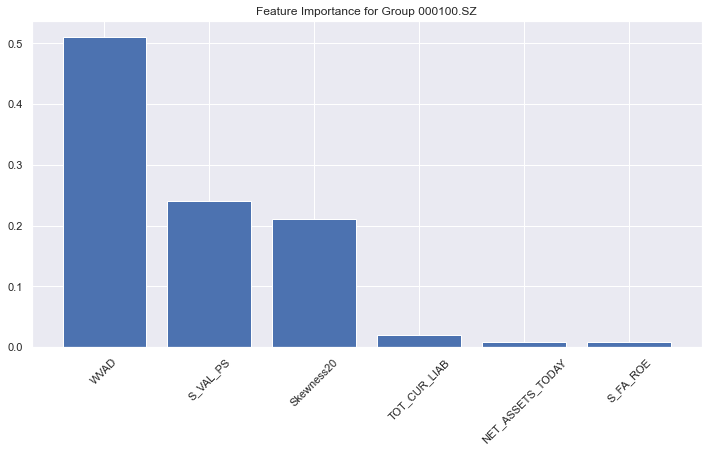

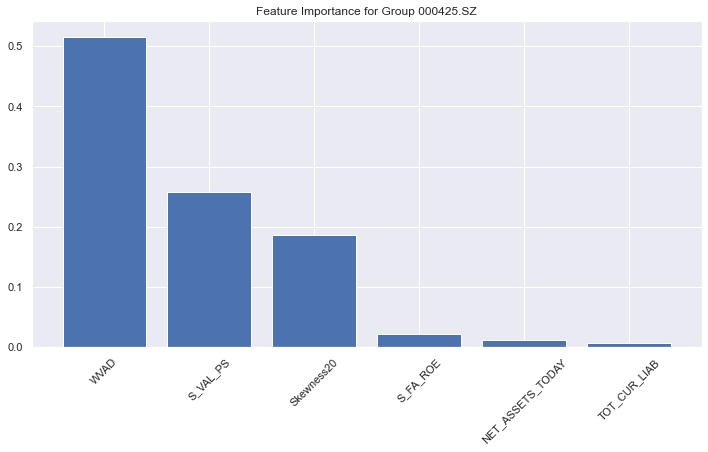

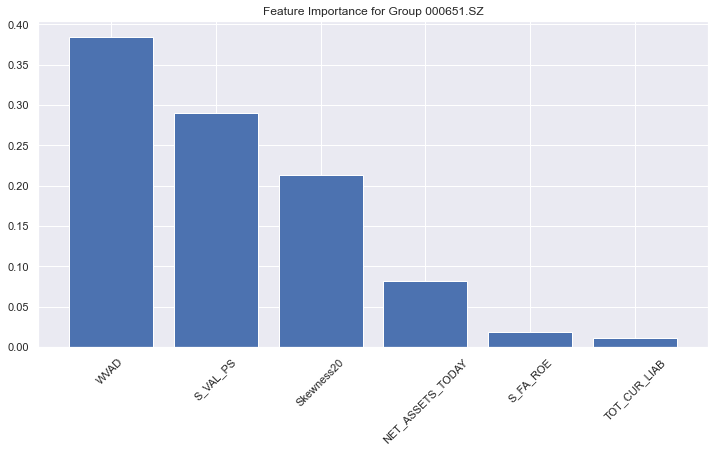

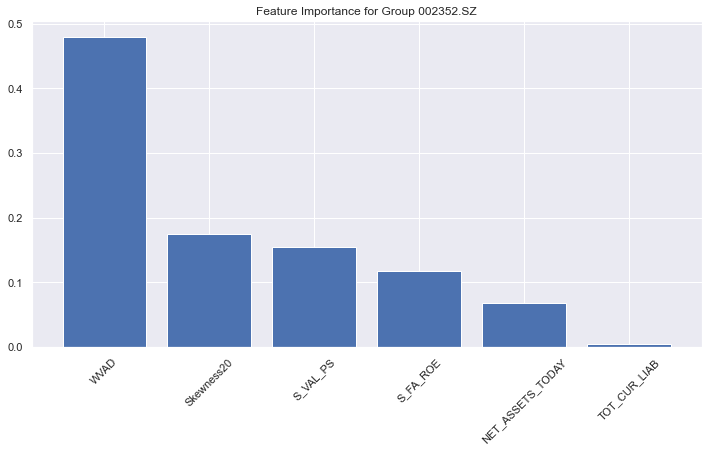

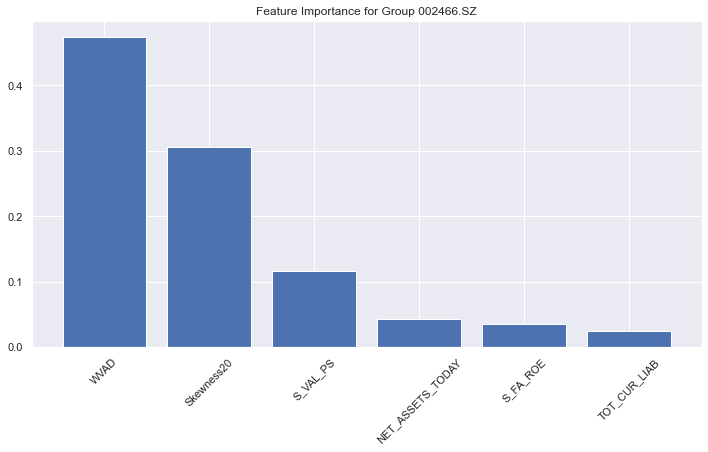

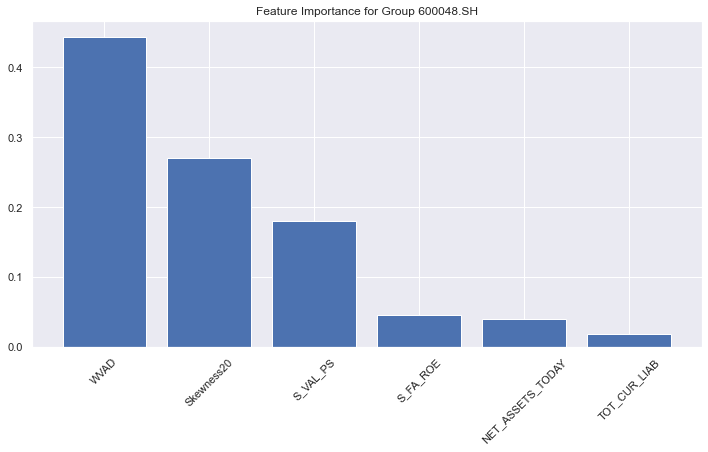

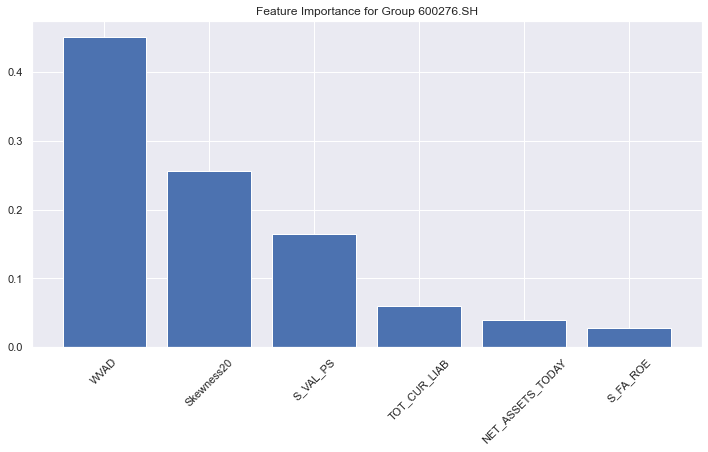

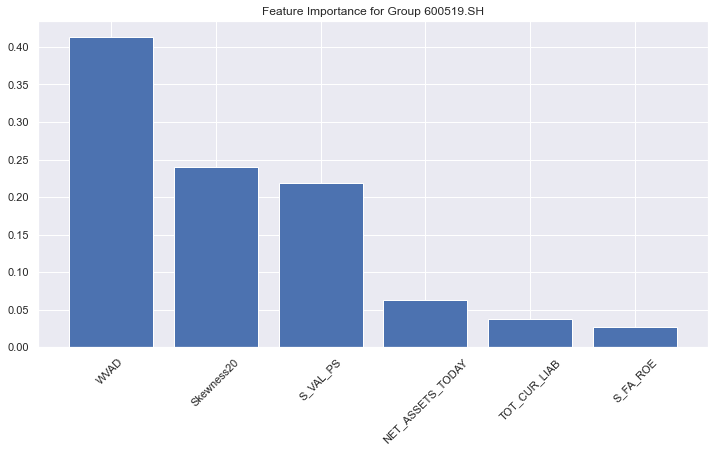

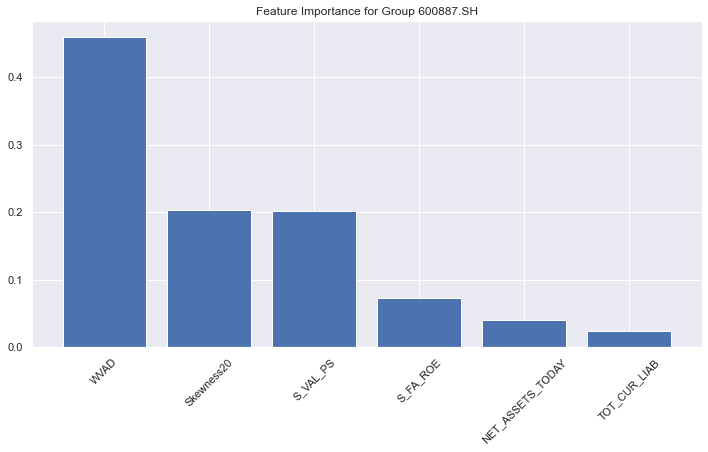

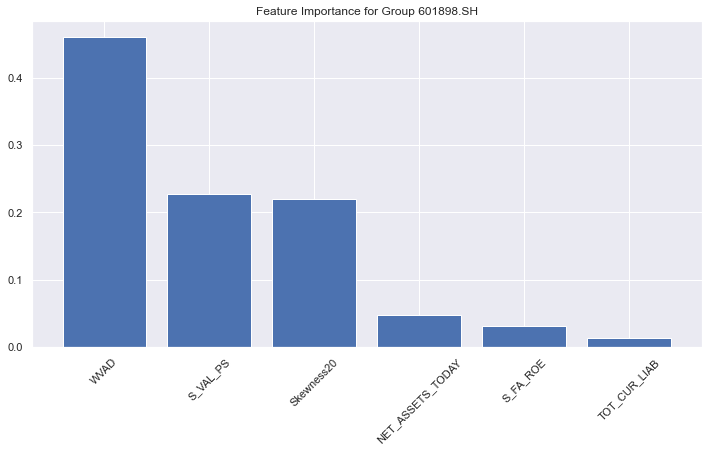

In [9]:
group_col = 'S_INFO_WINDCODE'
features = ['S_FA_ROE', 'Skewness20', 'WVAD', 'S_VAL_PS', 'NET_ASSETS_TODAY', 'TOT_CUR_LIAB']
target = 'ret'

model_dt = MultiFactorStockRegressionDT(
    group_col=group_col,
    features=features,
    target=target
)
model_dt.fit(train_data, validation_data)

unique_groups = train_data[group_col].unique()
for group in unique_groups:
    model_dt.plot_feature_importance(group)
    
predictions0 = model_dt.predict(test_data)
test_data['predicted_ret_dt'] = predictions0

In [10]:
class MultiFactorStockRegressionRF:
    def __init__(self, group_col, features, target):
        self.group_col = group_col
        self.features = features
        self.target = target
        self.models = {}
        self.best_rmse = {}
        self.rmse_history = {}

    def fit(self, train_data, validation_data, n_estimators=100, early_stopping_rounds=10):
        unique_groups = train_data[self.group_col].unique()

        for group in unique_groups:
            group_train_data = train_data[train_data[self.group_col] == group]
            X_train = group_train_data[self.features]
            y_train = group_train_data[self.target]

            group_val_data = validation_data[validation_data[self.group_col] == group]
            X_val = group_val_data[self.features]
            y_val = group_val_data[self.target]

            self.best_rmse[group] = float('inf')
            self.rmse_history[group] = []
            best_model = None
            rounds_without_improvement = 0
            best_iteration = 0

            for n in range(1, n_estimators + 1):
                model = RandomForestRegressor(n_estimators=n, random_state=42)
                model.fit
                model.fit(X_train, y_train)

                predictions = model.predict(X_val)
                rmse = mean_squared_error(y_val, predictions, squared=False)
                self.rmse_history[group].append(rmse)

                if rmse < self.best_rmse[group]:
                    self.best_rmse[group] = rmse
                    best_model = model
                    best_iteration = n
                    rounds_without_improvement = 0
                else:
                    rounds_without_improvement += 1

                if rounds_without_improvement >= early_stopping_rounds:
                    break

            self.models[group] = best_model
            print(f"Group {group} stopped at iteration {best_iteration - 1} with best RMSE: {self.best_rmse[group]}")

    def plot_rmse_history(self, group):
        if group not in self.rmse_history:
            print(f"No RMSE history data for group {group}")
            return

        plt.figure(figsize=(12,6))
        plt.plot(self.rmse_history[group], label='Validation RMSE')
        plt.xlabel('Number of Trees')
        plt.ylabel('RMSE')
        plt.title(f'RMSE History for Group {group}')
        plt.legend()
        plt.show()

    def plot_feature_importance(self, group):
        if group not in self.models:
            print(f"No model data for group {group}")
            return

        model = self.models[group]
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(12,6))
        plt.title(f'Feature Importance for Group {group}')
        plt.bar(range(len(indices)), importances[indices], align='center')
        plt.xticks(range(len(indices)), [self.features[i] for i in indices], rotation=45)
        plt.show()

    def predict(self, test_data):
        predictions = []

        for _, group_data in test_data.groupby(self.group_col):
            group = group_data.iloc[0][self.group_col]
            X_group = group_data[self.features]
            model = self.models[group]
            group_predictions = model.predict(X_group)
            predictions.extend(group_predictions)

        return predictions

Group 000100.SZ stopped at iteration 44 with best RMSE: 0.0209802476531626
Group 000425.SZ stopped at iteration 8 with best RMSE: 0.023942940107366795
Group 000651.SZ stopped at iteration 75 with best RMSE: 0.018587118622872763
Group 002352.SZ stopped at iteration 3 with best RMSE: 0.023251101360546728
Group 002466.SZ stopped at iteration 9 with best RMSE: 0.046216633453199214
Group 600048.SH stopped at iteration 10 with best RMSE: 0.029925473545661142
Group 600276.SH stopped at iteration 24 with best RMSE: 0.026204765437134892
Group 600519.SH stopped at iteration 11 with best RMSE: 0.021773695904225794
Group 600887.SH stopped at iteration 23 with best RMSE: 0.019026660138571457
Group 601898.SH stopped at iteration 7 with best RMSE: 0.03832757874986887


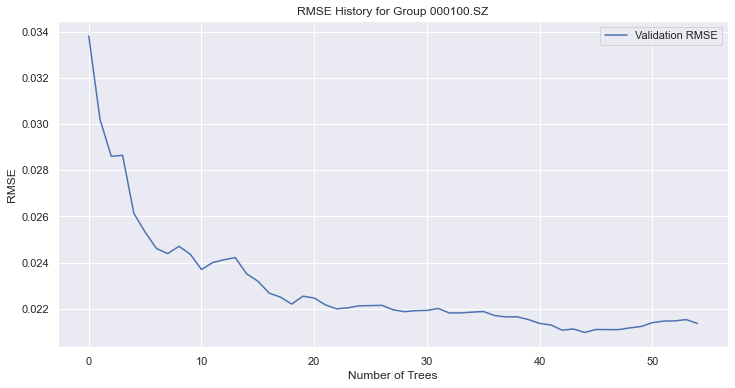

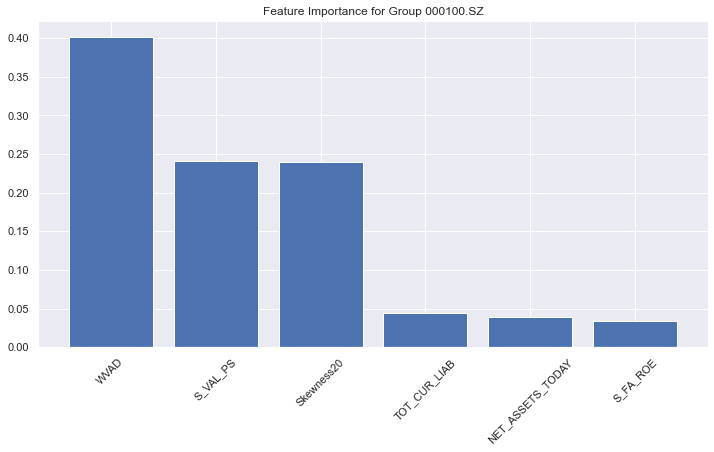

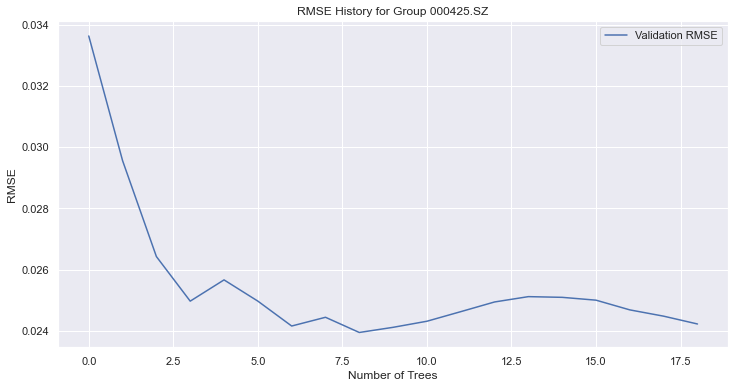

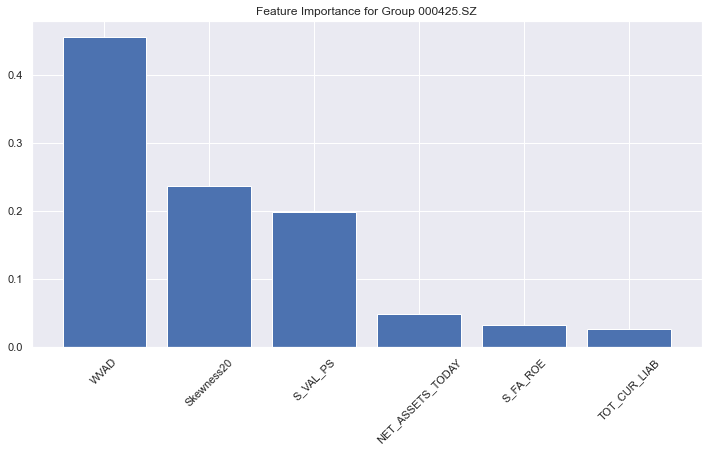

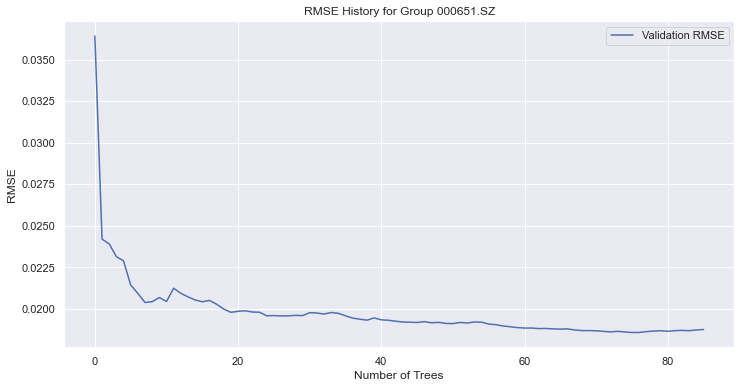

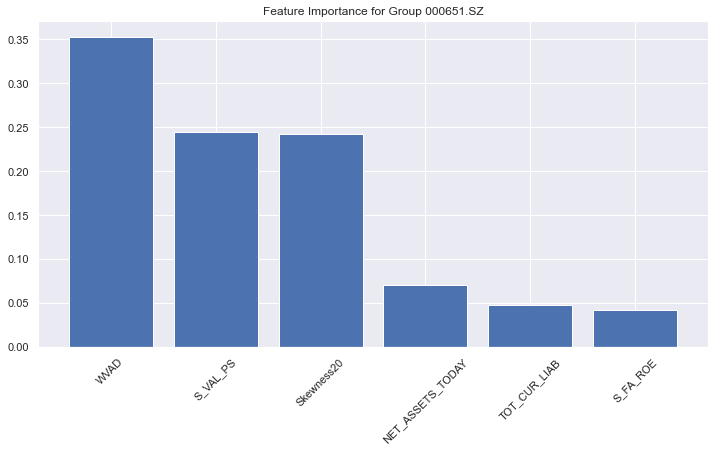

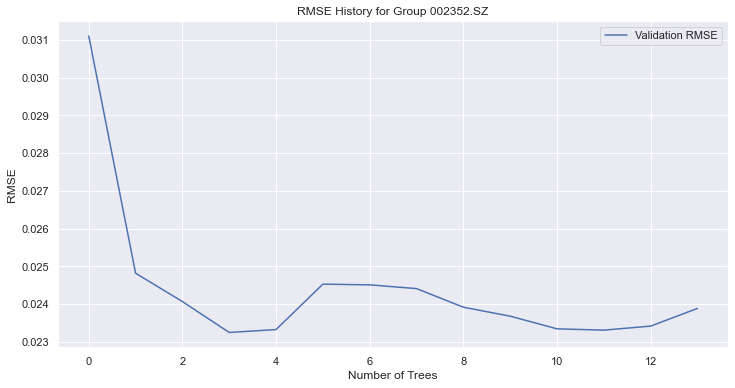

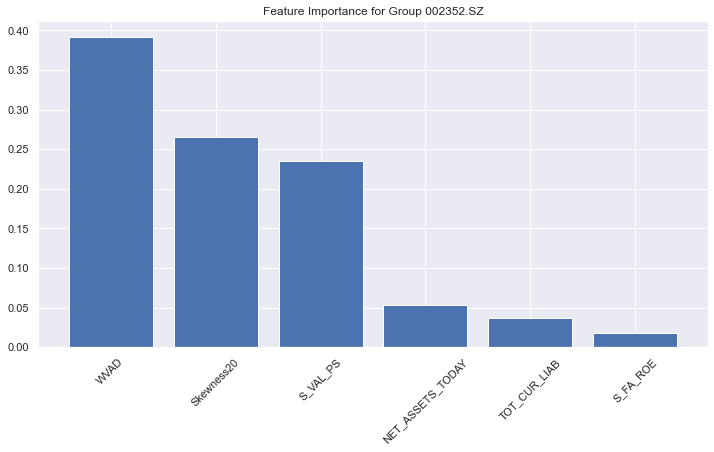

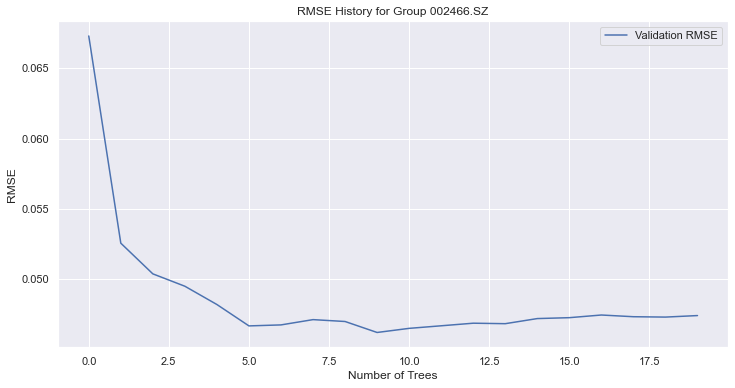

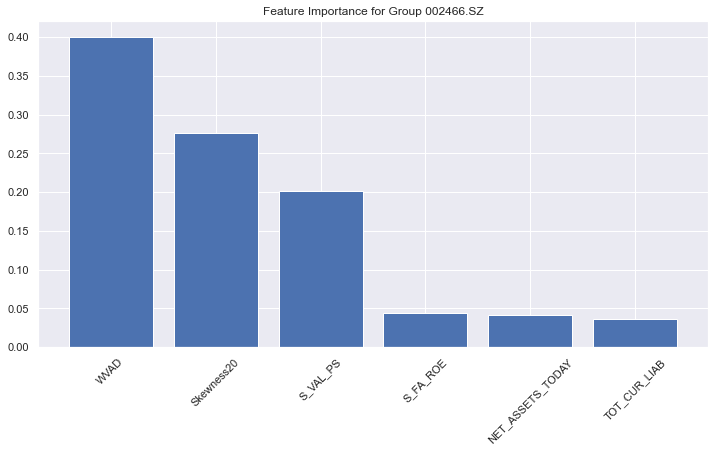

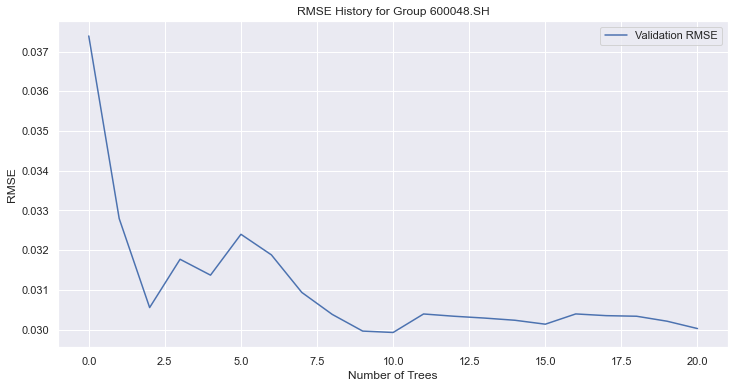

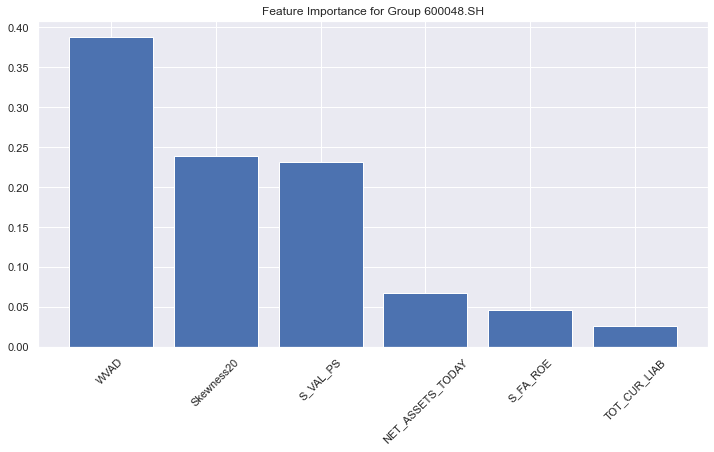

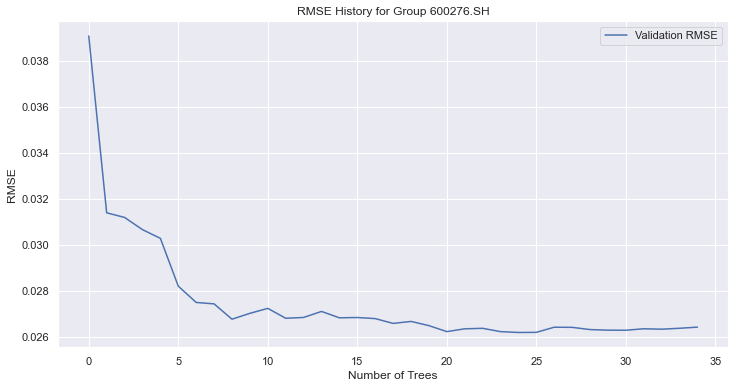

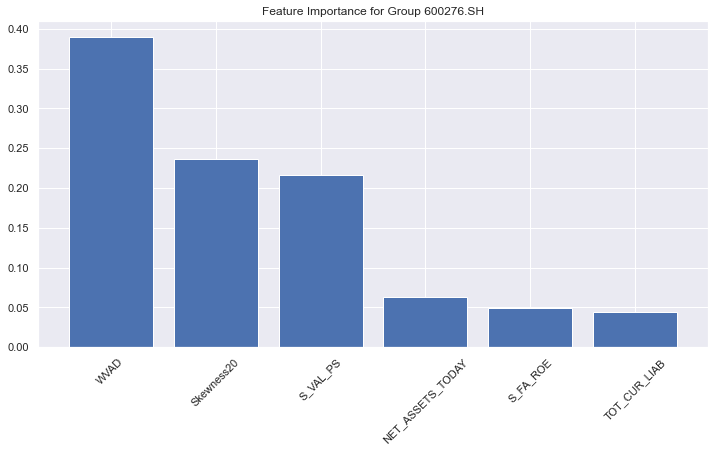

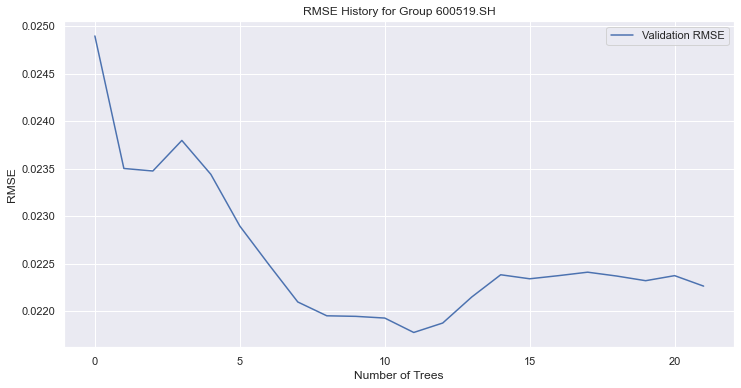

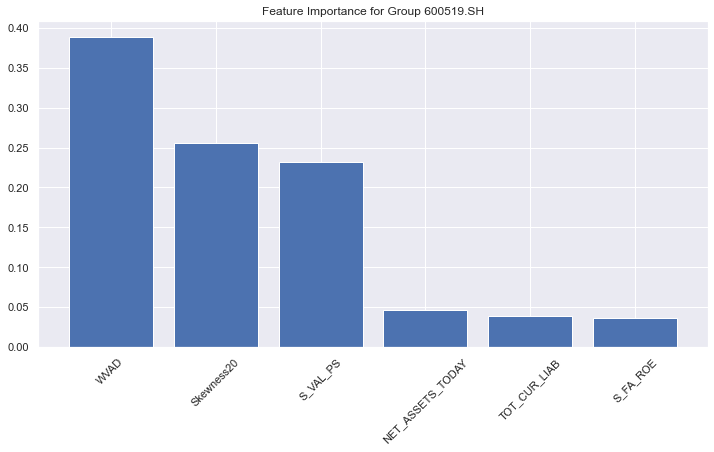

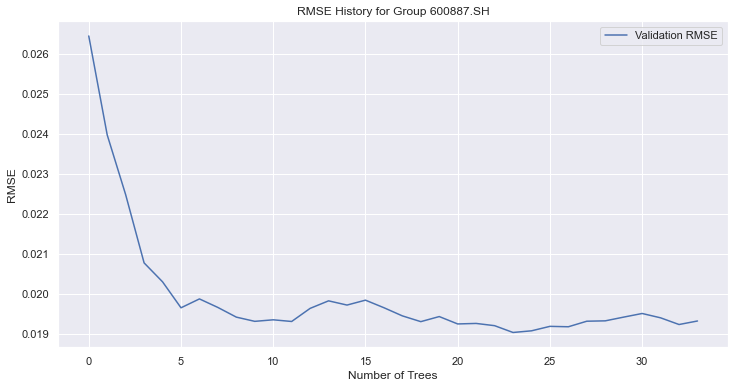

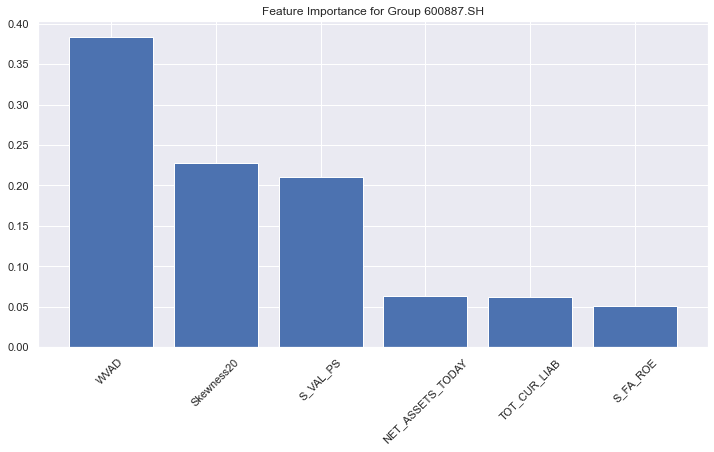

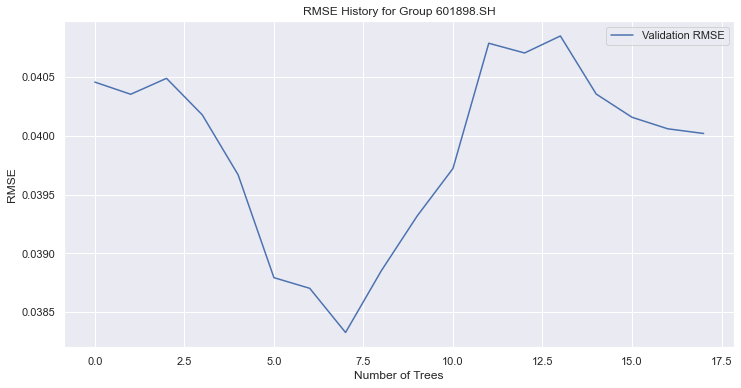

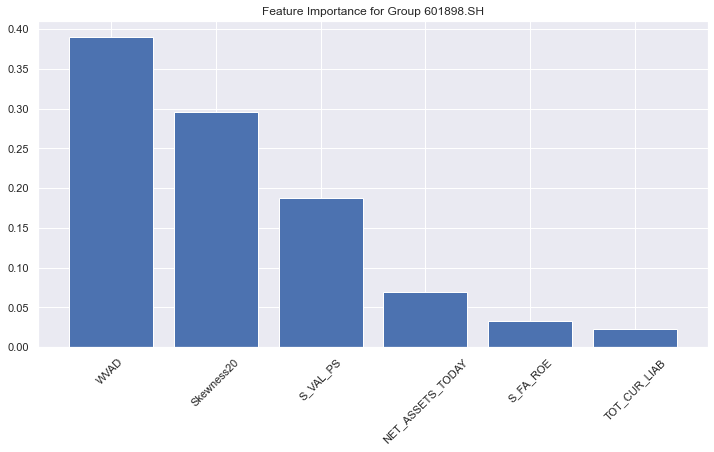

In [11]:
model_rf = MultiFactorStockRegressionRF(
    group_col=group_col,
    features=features,
    target=target
)

model_rf.fit(train_data, validation_data, n_estimators=100, early_stopping_rounds=10)
predictions2 = model_rf.predict(test_data)
test_data['predicted_ret_rf'] = predictions2

for group in unique_groups:
    model_rf.plot_rmse_history(group)
    model_rf.plot_feature_importance(group)

In [12]:
class MultiFactorStockRegressionXGB:
    def __init__(self, group_col, features, target):
        self.group_col = group_col
        self.features = features
        self.target = target
        self.models = {}
        self.evals_result = {}

    def fit(self, train_data, validation_data, early_stopping_rounds=10):
        unique_groups = train_data[self.group_col].unique()

        for group in unique_groups:
            group_train_data = train_data[train_data[self.group_col] == group]
            X_train = group_train_data[self.features]
            y_train = group_train_data[self.target]

            group_val_data = validation_data[validation_data[self.group_col] == group]
            X_val = group_val_data[self.features]
            y_val = group_val_data[self.target]

            model = xgb.XGBRegressor(n_estimators=1000, random_state=42, early_stopping_rounds=early_stopping_rounds)

            model.fit(X_train, y_train, 
                      eval_set=[(X_train, y_train), (X_val, y_val)], 
                      verbose=False)

            self.models[group] = model
            self.evals_result[group] = model.evals_result()  # 获取评估结果
            
            if model.best_iteration:
                print(f"Group {group} stopped early at iteration {model.best_iteration}")
            else:
                print(f"Group {group} did not stop early.")
            
    def plot_evaluation(self, group):
        if group not in self.evals_result:
            print(f"No evaluation data for group {group}")
            return

        evals_result = self.evals_result[group]
        if 'validation_0' in evals_result and 'rmse' in evals_result['validation_0']:
            epochs = len(evals_result['validation_0']['rmse'])
            x_axis = range(0, epochs)

            plt.figure(figsize=(12,6))
            plt.plot(x_axis, evals_result['validation_0']['rmse'], label='Train')
            plt.plot(x_axis, evals_result['validation_1']['rmse'], label='Validation')
            plt.legend()
            plt.ylabel('RMSE')
            plt.xlabel('Number of Iteration')
            plt.title(f'XGBoost RMSE for Group {group}')
            plt.show()
        else:
            print(f"No RMSE data for group {group}")

    def plot_feature_importance(self, group):
        if group not in self.models:
            print(f"No model data for group {group}")
            return

        model = self.models[group]
        xgb.plot_importance(model)
        plt.title(f'Feature Importance for Group {group}')
        plt.show()

    def predict(self, test_data):
        predictions = []

        for _, group_data in test_data.groupby(self.group_col):
            group = group_data.iloc[0][self.group_col]
            X_group = group_data[self.features]

            model = self.models[group]
            group_predictions = model.predict(X_group)
            predictions.extend(group_predictions)

        return predictions

Group 000100.SZ stopped early at iteration 1
Group 000425.SZ stopped early at iteration 1
Group 000651.SZ stopped early at iteration 1
Group 002352.SZ stopped early at iteration 1
Group 002466.SZ stopped early at iteration 6
Group 600048.SH stopped early at iteration 4
Group 600276.SH stopped early at iteration 1
Group 600519.SH did not stop early.
Group 600887.SH did not stop early.
Group 601898.SH did not stop early.


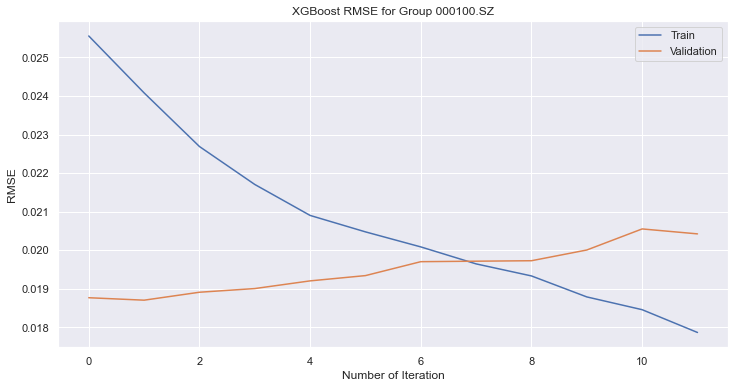

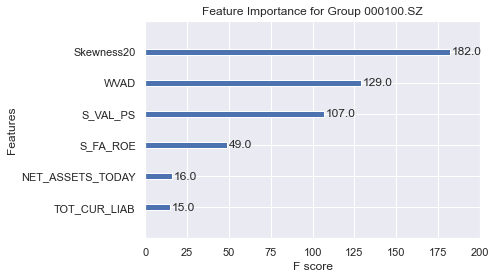

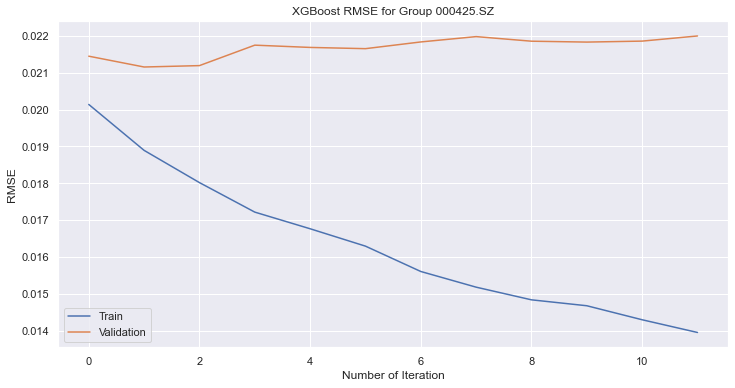

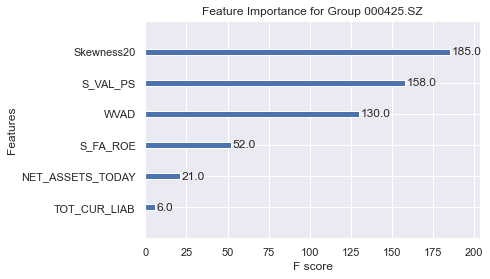

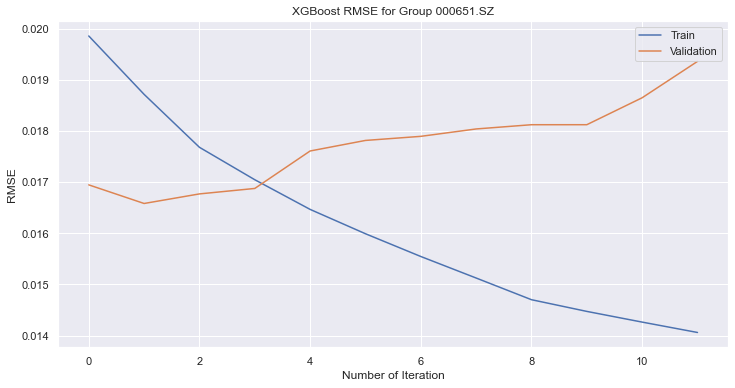

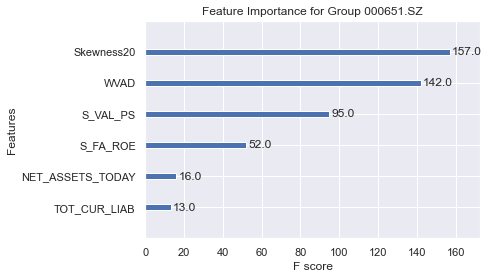

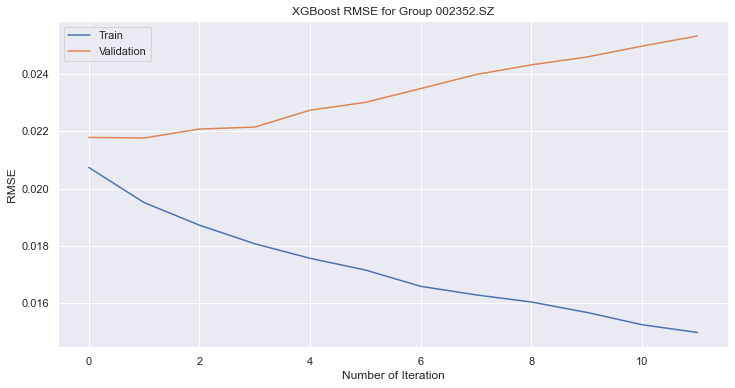

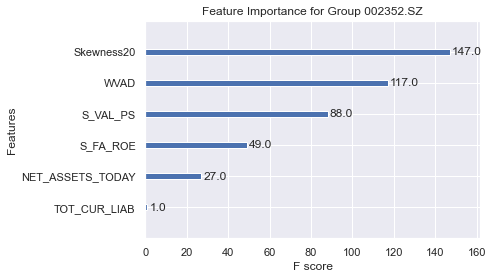

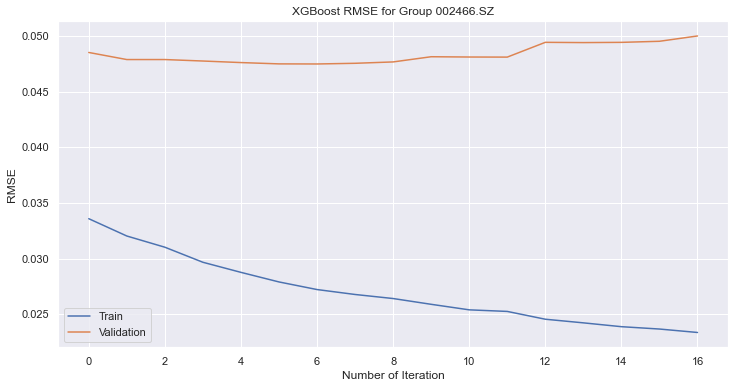

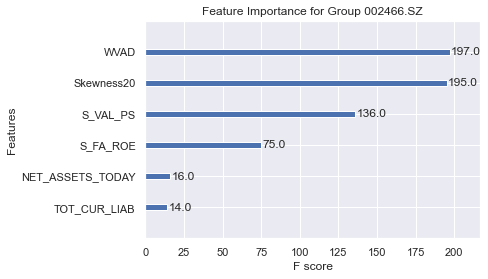

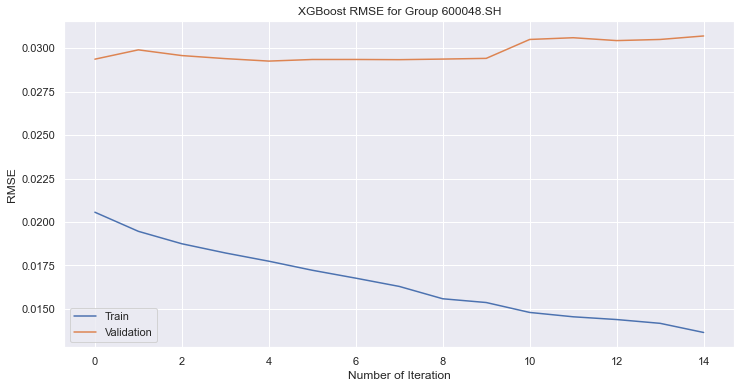

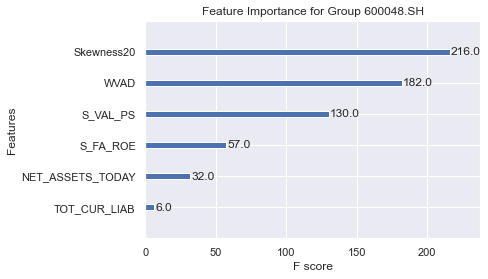

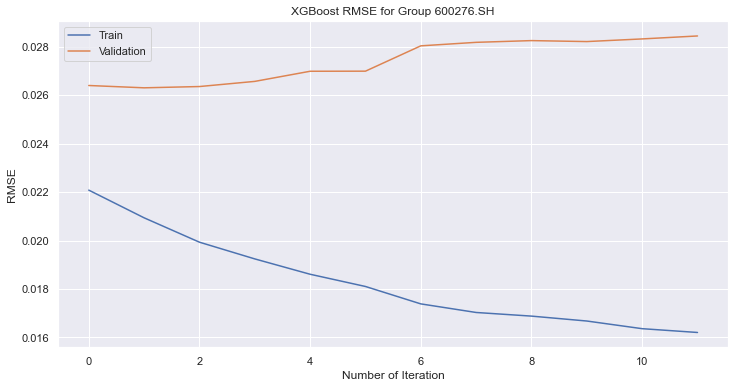

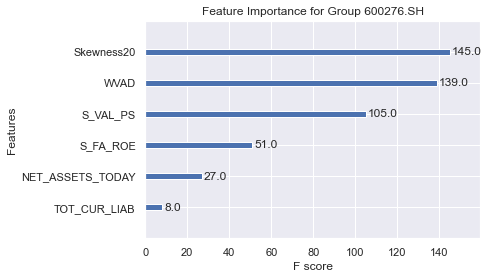

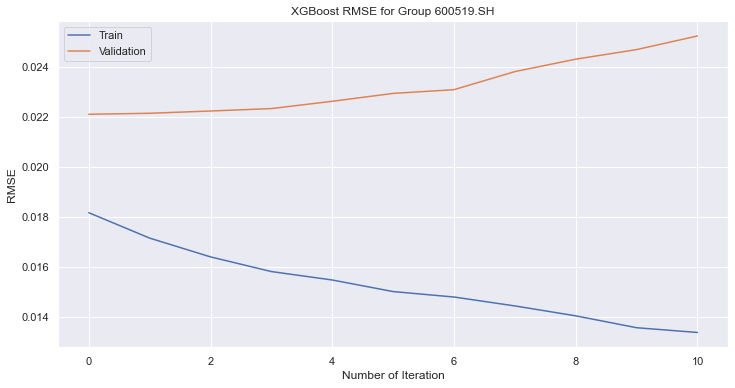

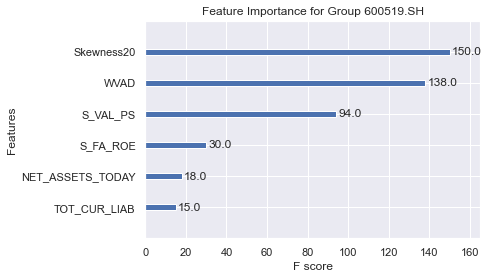

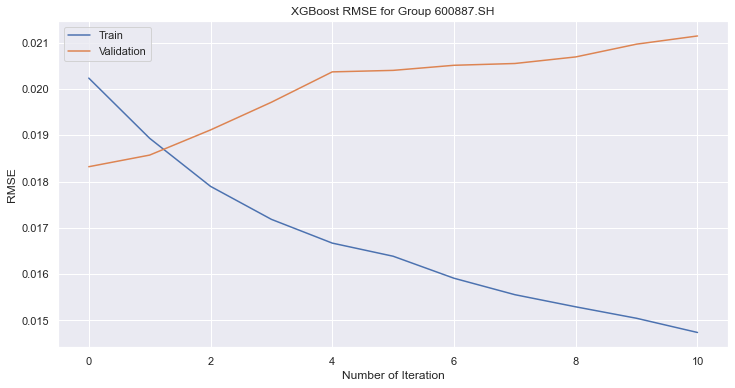

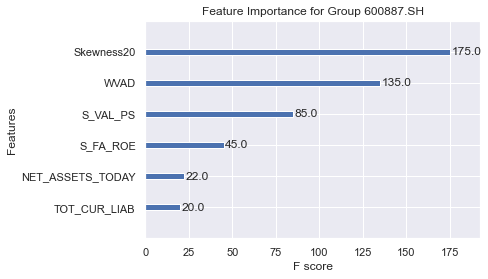

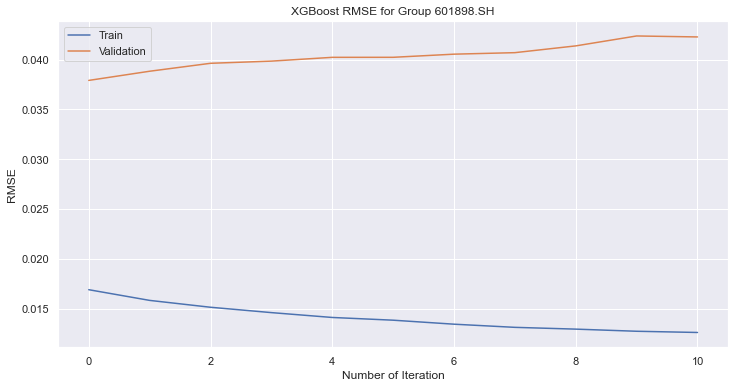

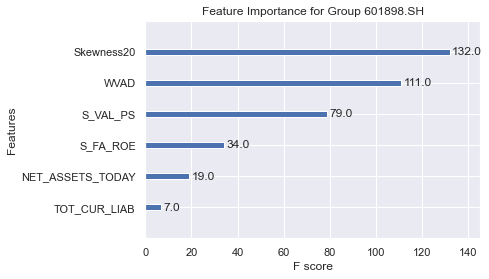

In [13]:
model_gb = MultiFactorStockRegressionXGB(
    group_col=group_col,
    features=features,
    target=target
)

model_gb.fit(train_data, validation_data)
predictions1 = model_gb.predict(test_data)
test_data['predicted_ret_gb'] = predictions1

for group in unique_groups:
    model_gb.plot_evaluation(group)
    model_gb.plot_feature_importance(group)

In [14]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask]))

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

performance_metrics = {'S_INFO_WINDCODE': [], 'Model': [], 'MSE': [], 'MAE': [], 'MAPE': [], 'RMSE': [], 'Adjusted R^2': []}

for code in unique_groups:
    data_for_stock = test_data[test_data['S_INFO_WINDCODE'] == code]
    
    predictions_dt = model_dt.predict(data_for_stock)
    predictions_rf = model_rf.predict(data_for_stock)
    predictions_gb = model_gb.predict(data_for_stock)
    actuals = data_for_stock['ret']

    mse_dt = mean_squared_error(actuals, predictions_dt)
    mse_rf = mean_squared_error(actuals, predictions_rf)
    mse_gb = mean_squared_error(actuals, predictions_gb)
    mae_dt = mean_absolute_error(actuals, predictions_dt)
    mae_rf = mean_absolute_error(actuals, predictions_rf)
    mae_gb = mean_absolute_error(actuals, predictions_gb)
    mape_dt = mean_absolute_percentage_error(actuals, predictions_dt)
    mape_rf = mean_absolute_percentage_error(actuals, predictions_rf)
    mape_gb = mean_absolute_percentage_error(actuals, predictions_gb)
    rmse_dt = root_mean_squared_error(actuals, predictions_dt)
    rmse_rf = root_mean_squared_error(actuals, predictions_rf)
    rmse_gb = root_mean_squared_error(actuals, predictions_gb)
    r2_dt = r2_score(actuals, predictions_dt)
    r2_rf = r2_score(actuals, predictions_rf)
    r2_gb = r2_score(actuals, predictions_gb)
    
    n = len(actuals)  
    k = 6  
    adjusted_r2_dt = 1 - (1 - r2_dt) * (n - 1) / (n - k - 1)

    performance_metrics['S_INFO_WINDCODE'].append(code)
    performance_metrics['Model'].append('DT')
    performance_metrics['MSE'].append(mse_dt)
    performance_metrics['MAE'].append(mae_dt)
    performance_metrics['MAPE'].append(mape_dt)
    performance_metrics['RMSE'].append(rmse_dt)
    performance_metrics['Adjusted R^2'].append(adjusted_r2_dt)

    performance_metrics['S_INFO_WINDCODE'].append(code)
    performance_metrics['Model'].append('RF')
    performance_metrics['MSE'].append(mse_rf)
    performance_metrics['MAE'].append(mae_rf)
    performance_metrics['MAPE'].append(mape_rf)
    performance_metrics['RMSE'].append(rmse_rf)
    performance_metrics['Adjusted R^2'].append(r2_rf)

    performance_metrics['S_INFO_WINDCODE'].append(code)
    performance_metrics['Model'].append('GBRT')
    performance_metrics['MSE'].append(mse_gb)
    performance_metrics['MAE'].append(mae_gb)
    performance_metrics['MAPE'].append(mape_gb)
    performance_metrics['RMSE'].append(rmse_gb)
    performance_metrics['Adjusted R^2'].append(r2_gb)

df_performance = pd.DataFrame(performance_metrics)
df_performance

S_INFO_WINDCODE Model       MSE       MAE      MAPE      RMSE  Adjusted R^2
0        000100.SZ    DT  0.000859  0.022254  2.521861  0.029301     -0.904536
1        000100.SZ    RF  0.000469  0.016467  1.557260  0.021654      0.011060
2        000100.SZ  GBRT  0.000428  0.015240  1.153992  0.020691      0.097009
3        000425.SZ    DT  0.000500  0.017155  2.108146  0.022358     -0.793564
4        000425.SZ    RF  0.000384  0.015986  1.930601  0.019591     -0.312998
5        000425.SZ  GBRT  0.000301  0.013141  1.235920  0.017354     -0.030296
6        000651.SZ    DT  0.000587  0.018405  2.576833  0.024223     -0.686549
7        000651.SZ    RF  0.000445  0.015904  2.026063  0.021105     -0.220791
8        000651.SZ  GBRT  0.000358  0.013466  1.155148  0.018908      0.020149
9        002352.SZ    DT  0.002140  0.037374  4.588326  0.046262     -2.338328
10       002352.SZ    RF  0.000795  0.022879  2.255203  0.028202     -0.182905
11       002352.SZ  GBRT  0.000792  0.021700  1.733342  0.028134     -0.177254
12       002466.SZ    DT  0.002331  0.037878  2.847826  0.048284     -0.607256
13       002466.SZ    RF  0.001984  0.034691  2.837395  0.044539     -0.302971
14       002466.SZ  GBRT  0.001755  0.031385  2.089388  0.041897     -0.152975
15       600048.SH    DT  0.000985  0.024823  2.394698  0.031388     -0.160119
16       600048.SH    RF  0.000917  0.023421  1.590390  0.030277     -0.029957
17       600048.SH  GBRT  0.000888  0.022636  1.209379  0.029794      0.002625
18       600276.SH    DT  0.001053  0.027398  5.933485  0.032457     -1.164841
19       600276.SH    RF  0.000567  0.019372  3.707013  0.023816     -0.112235
20       600276.SH  GBRT  0.000442  0.016124  2.164851  0.021034      0.132400
21       600519.SH    DT  0.000510  0.018479  2.959862  0.022572     -0.355191
22       600519.SH    RF  0.000439  0.016728  1.942345  0.020942     -0.112718
23       600519.SH  GBRT  0.000380  0.015297  1.274708  0.019492      0.036083
24       600887.SH    DT  0.000473  0.016753  3.680008  0.021753     -0.850598
25       600887.SH    RF  0.000302  0.013355  2.000604  0.017380     -0.127206
26       600887.SH  GBRT  0.000266  0.012010  1.197112  0.016301      0.008405
27       601898.SH    DT  0.001405  0.028945  2.301491  0.037479     -0.358920
28       601898.SH    RF  0.001401  0.029067  2.102735  0.037435     -0.291685
29       601898.SH  GBRT  0.001098  0.024742  1.183136  0.033138     -0.012198

In [15]:
performance_metrics = {'Model': [], 'MSE': [], 'MAE': [], 'MAPE': [], 'RMSE': [], 'Adjusted R^2': []}

predictions_dt = model_dt.predict(test_data)
actuals_dt = test_data['ret']

mse_dt = mean_squared_error(actuals_dt, predictions_dt)
mae_dt = mean_absolute_error(actuals_dt, predictions_dt)
mape_dt = mean_absolute_percentage_error(actuals_dt, predictions_dt)
rmse_dt = root_mean_squared_error(actuals_dt, predictions_dt)
r2_dt = r2_score(actuals_dt, predictions_dt)

n = len(actuals_dt)  
k = 6  
adjusted_r2_dt = 1 - (1 - r2_dt) * (n - 1) / (n - k - 1)

performance_metrics['Model'].append('DT')
performance_metrics['MSE'].append(mse_dt)
performance_metrics['MAE'].append(mae_dt)
performance_metrics['MAPE'].append(mape_dt)
performance_metrics['RMSE'].append(rmse_dt)
performance_metrics['Adjusted R^2'].append(adjusted_r2_dt)

predictions_rf = model_rf.predict(test_data)
actuals_rf = test_data['ret']

mse_rf = mean_squared_error(actuals_rf, predictions_rf)
mae_rf = mean_absolute_error(actuals_rf, predictions_rf)
mape_rf = mean_absolute_percentage_error(actuals_rf, predictions_rf)
rmse_rf = root_mean_squared_error(actuals_rf, predictions_rf)
r2_rf = r2_score(actuals_rf, predictions_rf)

n = len(actuals_rf)  
k = 6  
adjusted_r2_rf = 1 - (1 - r2_rf) * (n - 1) / (n - k - 1)

performance_metrics['Model'].append('RF')
performance_metrics['MSE'].append(mse_rf)
performance_metrics['MAE'].append(mae_rf)
performance_metrics['MAPE'].append(mape_rf)
performance_metrics['RMSE'].append(rmse_rf)
performance_metrics['Adjusted R^2'].append(adjusted_r2_rf)

predictions_gb = model_gb.predict(test_data)
actuals_gb = test_data['ret']

mse_gb = mean_squared_error(actuals_gb, predictions_gb)
mae_gb = mean_absolute_error(actuals_gb, predictions_gb)
mape_gb = mean_absolute_percentage_error(actuals_gb, predictions_gb)
rmse_gb = root_mean_squared_error(actuals_gb, predictions_gb)
r2_gb = r2_score(actuals_gb, predictions_gb)

n = len(actuals_gb)  
k = 6  
adjusted_r2_gb = 1 - (1 - r2_gb) * (n - 1) / (n - k - 1)

performance_metrics['Model'].append('GBRT')
performance_metrics['MSE'].append(mse_gb)
performance_metrics['MAE'].append(mae_gb)
performance_metrics['MAPE'].append(mape_gb)
performance_metrics['RMSE'].append(rmse_gb)
performance_metrics['Adjusted R^2'].append(adjusted_r2_gb)

df_performance = pd.DataFrame(performance_metrics)
df_performance

Model       MSE       MAE      MAPE      RMSE  Adjusted R^2
0    DT  0.001081  0.024921  3.209579  0.032886     -0.677973
1    RF  0.000768  0.020763  2.203817  0.027713     -0.191615
2  GBRT  0.000669  0.018553  1.445080  0.025863     -0.037784

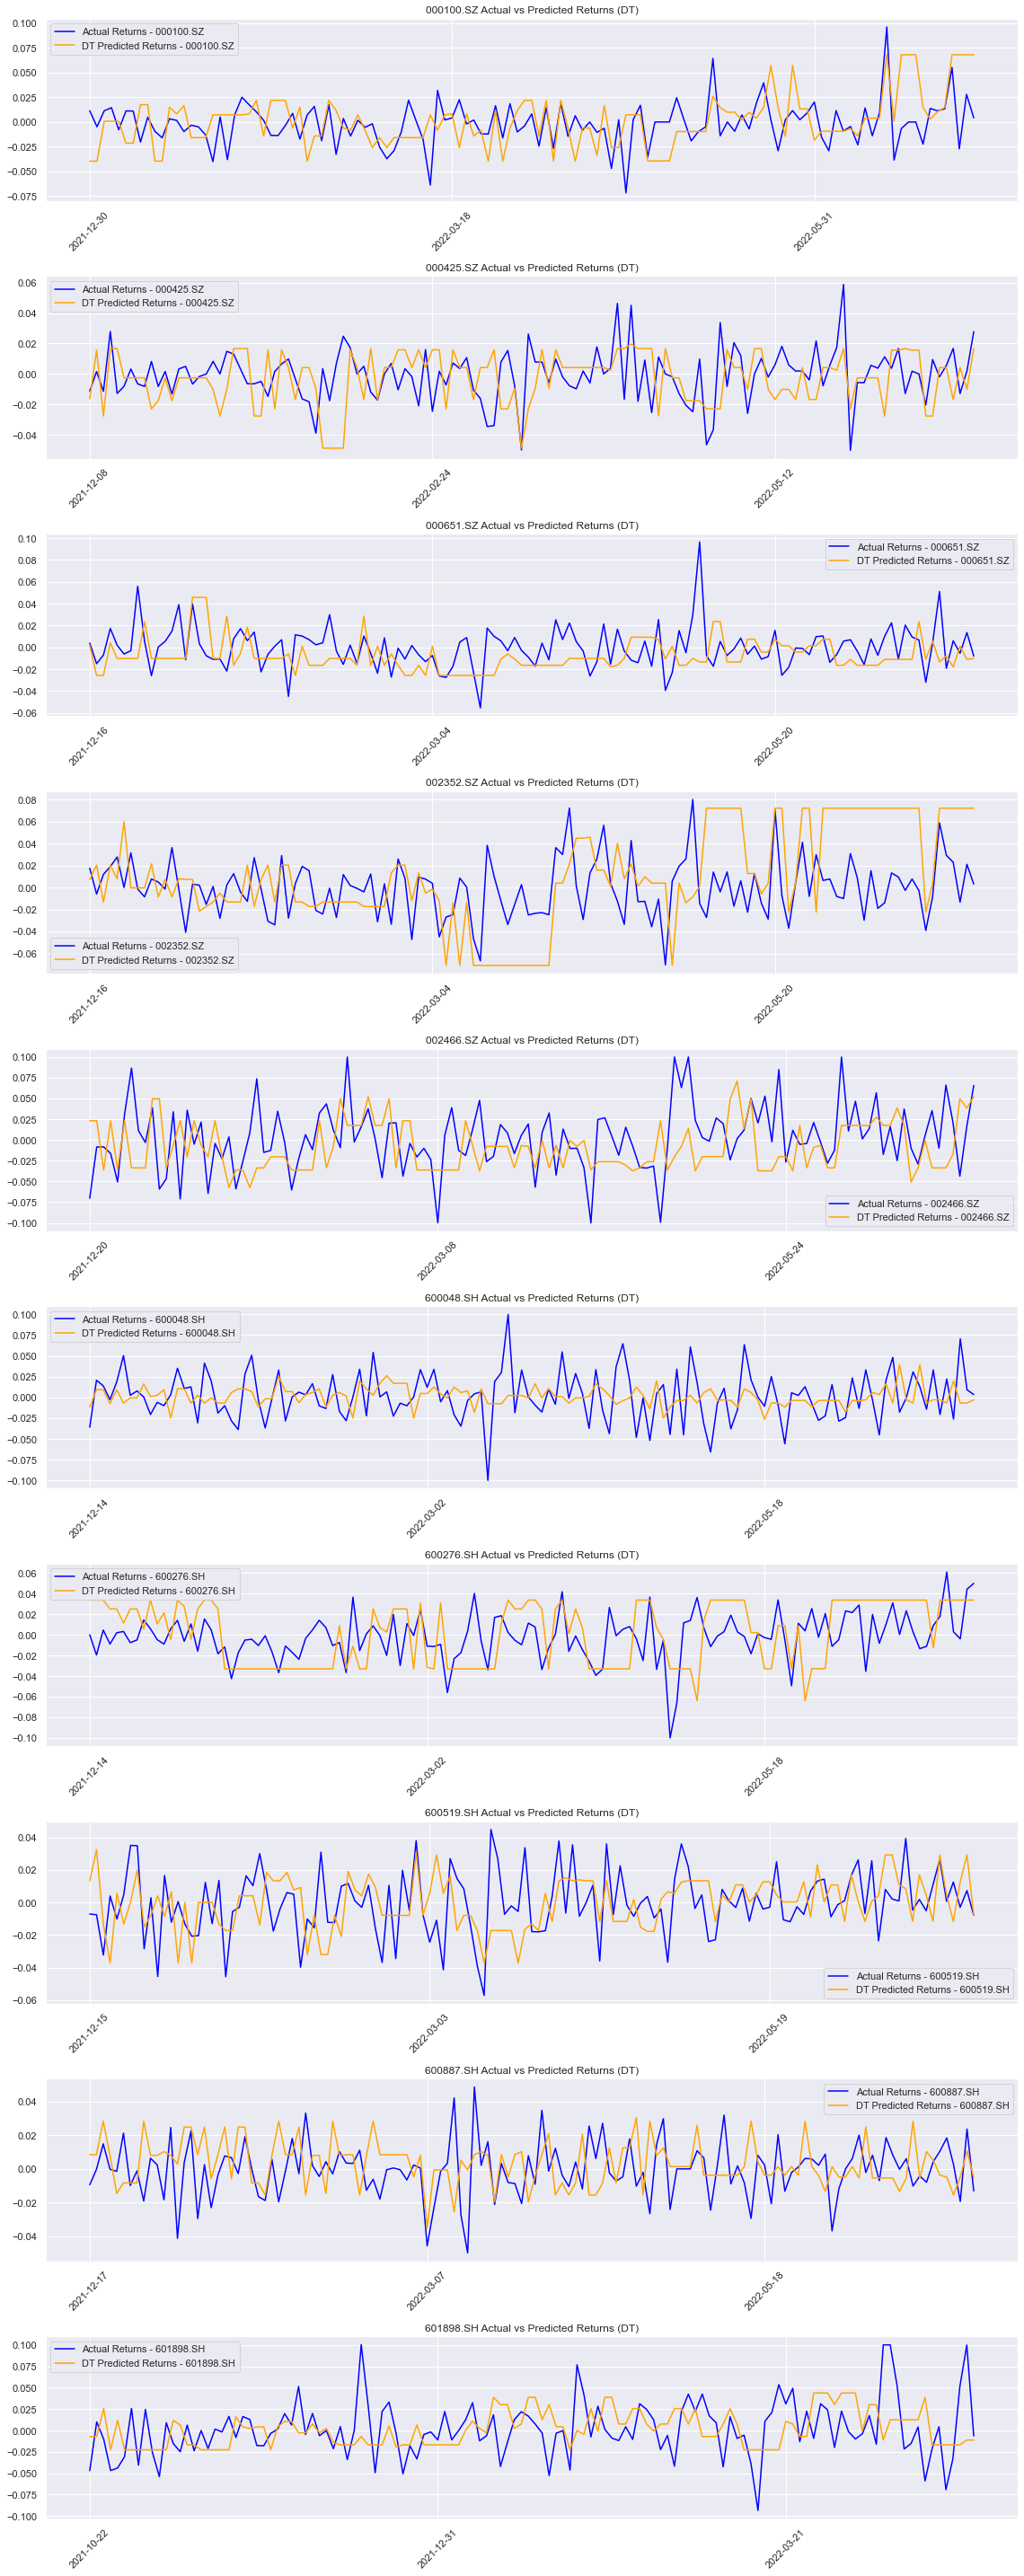

In [16]:
plt.figure(figsize=(16, 40))  
num_plots = len(unique_groups)

for i, stock_code in enumerate(unique_groups):
    stock_data = test_data[test_data['S_INFO_WINDCODE'] == stock_code]
    x_range = np.arange(stock_data.shape[0])
    plt.subplot(num_plots, 1, i + 1)
    plt.plot(x_range, stock_data['ret'], label=f'Actual Returns - {stock_code}', color='blue')
    plt.plot(x_range, stock_data['predicted_ret_dt'], label=f'DT Predicted Returns - {stock_code}', color='orange')
    plt.legend()
    plt.xticks(x_range[::50], stock_data['TRADE_DT'].dt.strftime('%Y-%m-%d')[::50], rotation=45)
    plt.title(f'{stock_code} Actual vs Predicted Returns (DT)')

plt.tight_layout() 
plt.show()

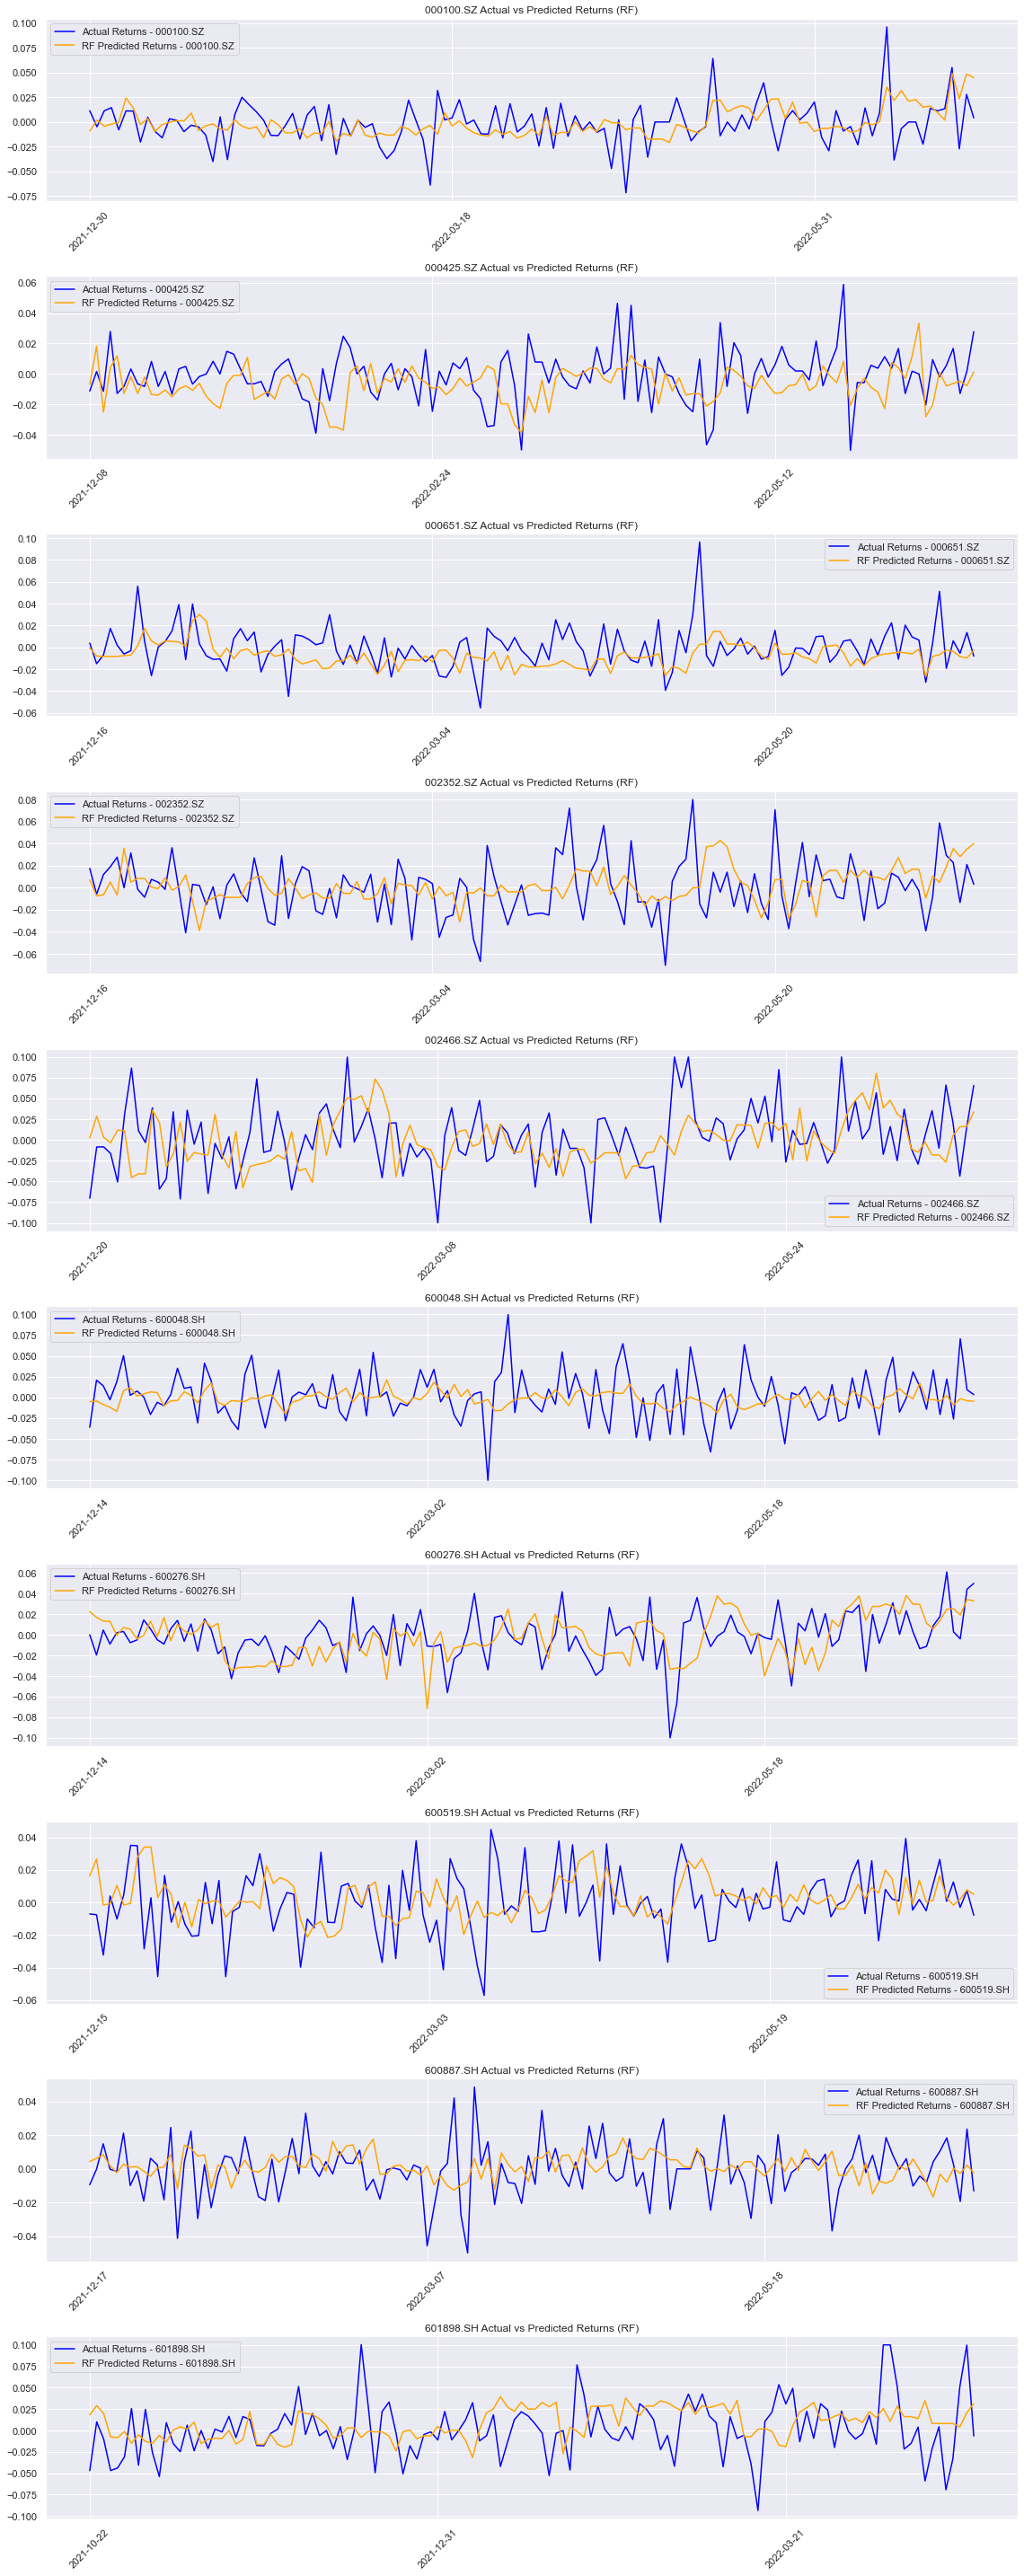

In [17]:
plt.figure(figsize=(16, 40))  
num_plots = len(unique_groups)

for i, stock_code in enumerate(unique_groups):
    stock_data = test_data[test_data['S_INFO_WINDCODE'] == stock_code]
    x_range = np.arange(stock_data.shape[0])
    plt.subplot(num_plots, 1, i + 1)
    plt.plot(x_range, stock_data['ret'], label=f'Actual Returns - {stock_code}', color='blue')
    plt.plot(x_range, stock_data['predicted_ret_rf'], label=f'RF Predicted Returns - {stock_code}', color='orange')
    plt.legend()
    plt.xticks(x_range[::50], stock_data['TRADE_DT'].dt.strftime('%Y-%m-%d')[::50], rotation=45)
    plt.title(f'{stock_code} Actual vs Predicted Returns (RF)')

plt.tight_layout() 
plt.show()

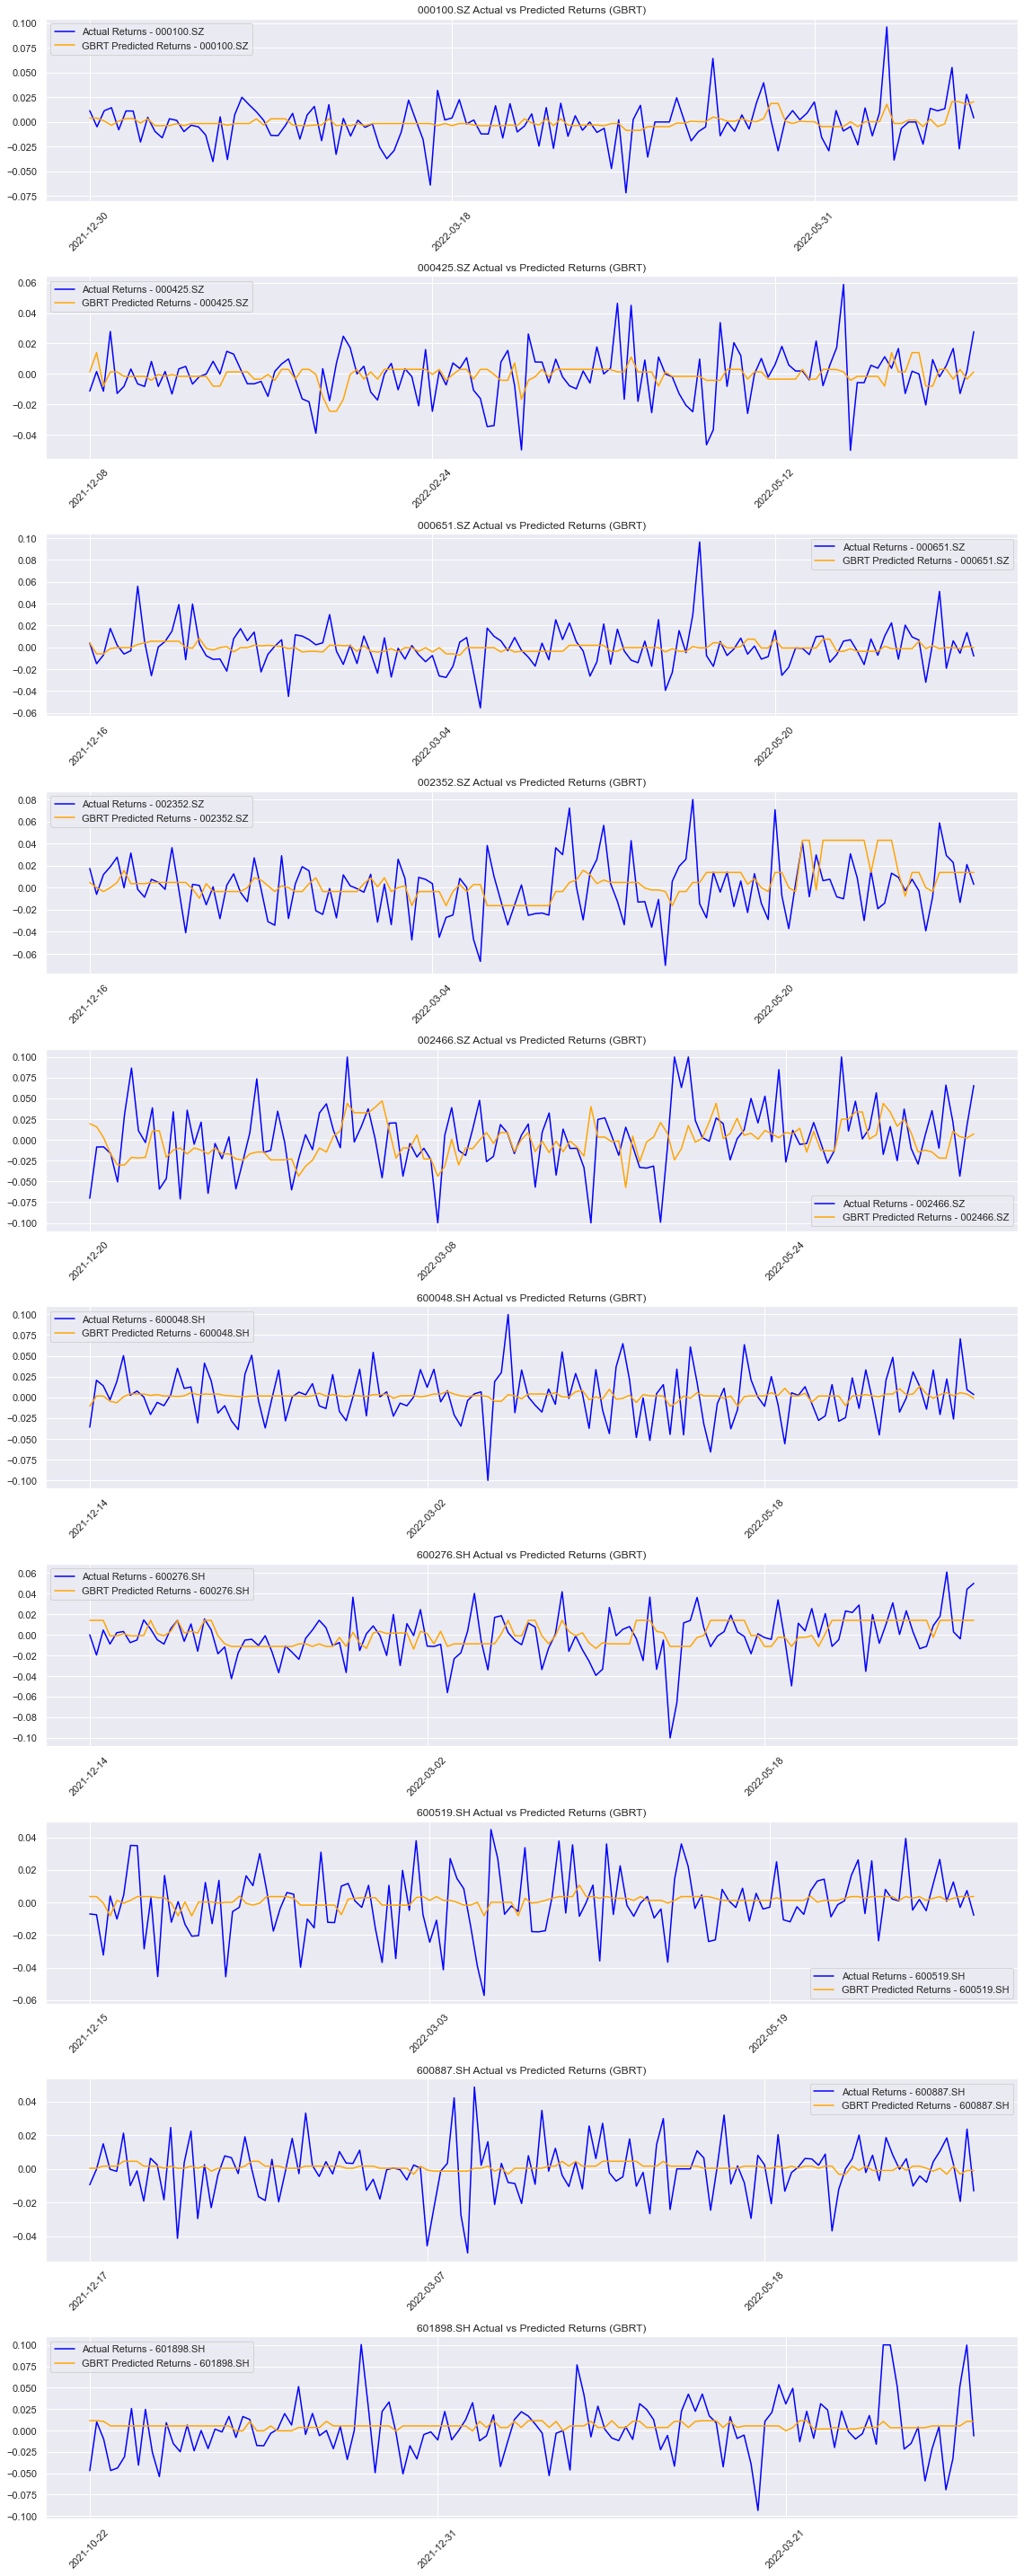

In [18]:
plt.figure(figsize=(16, 40))  
num_plots = len(unique_groups)

for i, stock_code in enumerate(unique_groups):
    stock_data = test_data[test_data['S_INFO_WINDCODE'] == stock_code]
    x_range = np.arange(stock_data.shape[0])
    plt.subplot(num_plots, 1, i + 1)
    plt.plot(x_range, stock_data['ret'], label=f'Actual Returns - {stock_code}', color='blue')
    plt.plot(x_range, stock_data['predicted_ret_gb'], label=f'GBRT Predicted Returns - {stock_code}', color='orange')
    plt.legend()
    plt.xticks(x_range[::50], stock_data['TRADE_DT'].dt.strftime('%Y-%m-%d')[::50], rotation=45)
    plt.title(f'{stock_code} Actual vs Predicted Returns (GBRT)')

plt.tight_layout() 
plt.show()